<a href="https://colab.research.google.com/github/KatrineME/DTU_DeepLearning/blob/main/DL_Project9_Mask_RCNN_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask RCNN algortihm 

The following code is based upon the tutorial made by Pytorch:

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

#Install

In [8]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-p6w5_1z6
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-p6w5_1z6
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=265567 sha256=edea726cd83a41a9a118805db050b13bfb0acc2dc0577d43a048992d1862d950
  Stored in directory: /tmp/pip-ephem-wheel-cache-0soa80gm/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


#Load data and packages

In [9]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import ast
import PIL
import cv2
import re
import torch

from IPython.display import clear_output
from skimage.io import imread
from skimage.measure import label
from skimage.transform import resize
from PIL import Image
from skimage import color
from skimage import io
from torch import Tensor

In [10]:
#Mount google drive for dataloading
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Deep')

train_anno = np.sort(glob.glob("/content/drive/My Drive/Deep/Warwick/train_*[0-9]_anno.bmp"))
train_img  = np.sort(glob.glob("/content/drive/My Drive/Deep/Warwick/train_*[0-9].bmp"))

test_anno = np.sort(glob.glob("/content/drive/My Drive/Deep/Warwick/test*_*[0-9]_anno.bmp"))
test_img  = np.sort(glob.glob("/content/drive/My Drive/Deep/Warwick/test*_*[0-9].bmp"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Ordering of data samples

In [11]:
# Training
train_a_list = [0]*len(train_anno)
train_i_list = [0]*len(train_img)

for i in range(0,len(train_anno)):
  a = int(re.findall(r'[0-9]+',train_anno[i])[0])
  train_a_list[i] = a

  m = int(re.findall(r'[0-9]+',train_img[i])[0])
  train_i_list[i] = m  

#print("Train anno: ",train_a_list)
#print("Train image: ",train_i_list)

# Test
test_a_list = [0]*len(test_anno)
test_i_list = [0]*len(test_img)

for i in range(0,len(test_anno)):
  if i > 59:  
    a = int(re.findall(r'[0-9]+',test_anno[i])[0])
    test_a_list[i] = a+60

    m = int(re.findall(r'[0-9]+',test_img[i])[0])
    test_i_list[i] = m+60

  else:
    a = int(re.findall(r'[0-9]+',test_anno[i])[0])
    test_a_list[i] = a

    m = int(re.findall(r'[0-9]+',test_img[i])[0])
    test_i_list[i] = m

#print("Test anno: ",test_a_list)
#print("Test image: ",test_i_list)

img_train_order  = [0]*len(train_img)
anno_train_order = [0]*len(train_anno)

for i in range(0,len(train_i_list)):
    for j in range(0,len(train_a_list)):
        if train_i_list[i] == train_a_list[j]:
           #print('i=',i,'j=',j)
           img_train_order[i]  =  train_img[i]
           anno_train_order[i] =  train_anno[j]
        else:
          1+1 # just something
    #print(img_train_order[i])
    #print(anno_train_order[i])

img_test_order  = [0]*len(test_img)
anno_test_order = [0]*len(test_anno)

for i in range(0,len(test_i_list)):
    for j in range(0,len(test_a_list)):
        if test_i_list[i] == test_a_list[j]:
           #print('i=',i,'j=',j)
           img_test_order[i]  =  test_img[i]
           anno_test_order[i] =  test_anno[j]
        else:
          1+1 # just something
    #print(img_test_order[i])
    #print(anno_test_order[i])


#Training data example

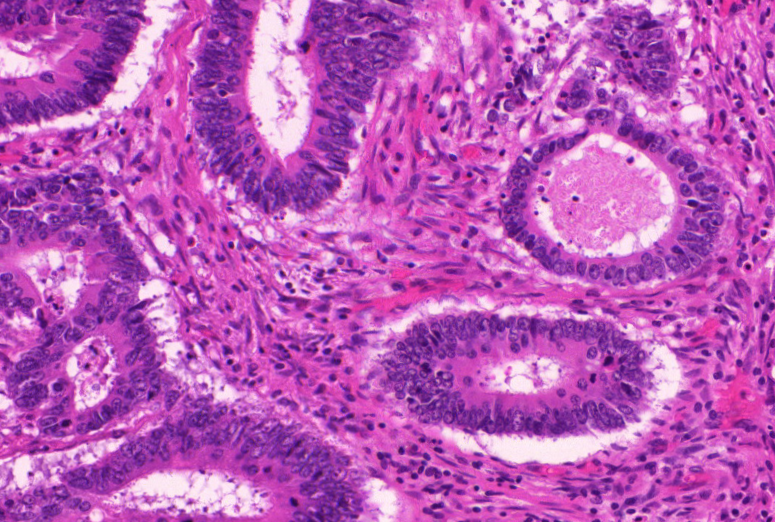

In [12]:
#from PIL import Image
Image.open(img_train_order[0])

#Mask example


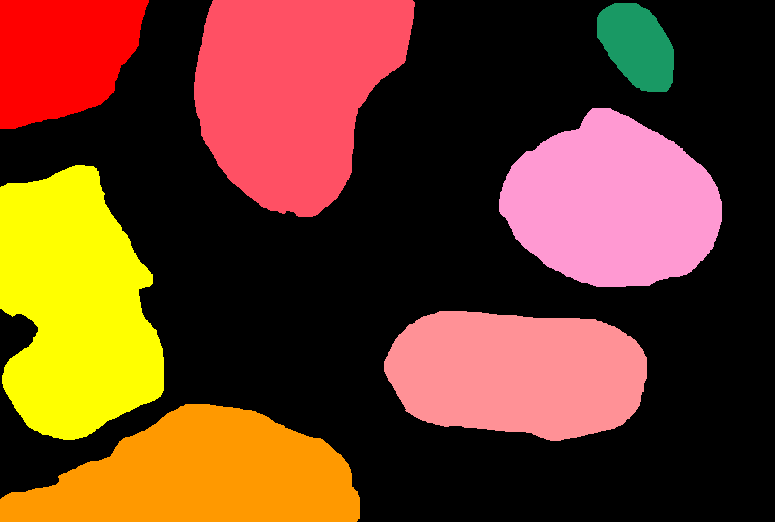

In [13]:
mask = Image.open(anno_train_order[0])
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
    255, 80, 100, # index 4 
    255, 145, 150, # index 5 
    255, 153, 210, # index 6 
    25, 153, 100, # index 7 
])
mask

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

#Network architecture

In [14]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, transforms=None):
        #self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs  = img_train_order  
        self.masks = anno_train_order  

    def __getitem__(self, idx):
        # load images ad masks
        img_path  = self.imgs[idx]
        mask_path = self.masks[idx]
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        #print(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        #print('Numberof objects: ',num_objs)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            if (xmin!=xmax and ymin!=ymax):
                boxes.append([xmin, ymin, xmax, ymax])
        #print(boxes)
        boxes = torch.as_tensor(boxes,   dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks,   dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])


        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"]    = boxes
        target["labels"]   = labels
        target["masks"]    = masks
        target["image_id"] = image_id
        target["area"]     = area
        target["iscrowd"]  = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [15]:
# Inspecting data set structure:
dataset = PennFudanDataset()
dataset[0]


(<PIL.Image.Image image mode=RGB size=775x522 at 0x7F94400BC9B0>,
 {'area': tensor([18944., 44662., 42003., 47520., 33798., 39516.,  6688.]),
  'boxes': tensor([[  0.,   0., 148., 128.],
          [  0., 165., 163., 439.],
          [  0., 404., 359., 521.],
          [194.,   0., 414., 216.],
          [384., 311., 646., 440.],
          [499., 108., 721., 286.],
          [597.,   3., 673.,  91.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
  'masks': tensor([[[1, 1, 1,  ..., 0, 0, 0],
           [1, 1, 1,  ..., 0, 0, 0],
           [1, 1, 1,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0,

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

#Import model
Instance segmentation model pre-trained on COCO

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [17]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
error: Your local changes to the following files would be overwritten by checkout:
	.circleci/regenerate.py
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	packaging/build_cmake.sh
	packaging/build_conda.sh
	packaging/build_wheel.sh
	packaging/conda/build_vision.sh
	packaging/conda/switch_cuda_version.sh
	travis-scripts/run-clang-format/run-clang-format.py
Please commit your changes or stash them before you switch branches.
Aborting




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [18]:
from   engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [19]:
# use our dataset and defined transformations
dataset = PennFudanDataset(get_transform(train=True))
dataset_test = PennFudanDataset(get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(params, lr=0.005, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [21]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/18]  eta: 0:01:10  lr: 0.000299  loss: 7.0626 (7.0626)  loss_classifier: 0.5319 (0.5319)  loss_box_reg: 0.5791 (0.5791)  loss_mask: 5.6393 (5.6393)  loss_objectness: 0.2467 (0.2467)  loss_rpn_box_reg: 0.0656 (0.0656)  time: 3.9203  data: 3.2922  max mem: 2364
Epoch: [0]  [10/18]  eta: 0:00:07  lr: 0.003237  loss: 2.5872 (3.4496)  loss_classifier: 0.4911 (0.4864)  loss_box_reg: 0.6272 (0.6607)  loss_mask: 1.2913 (2.0236)  loss_objectness: 0.1401 (0.2131)  loss_rpn_box_reg: 0.0575 (0.0658)  time: 0.9942  data: 0.5634  max mem: 2880
Epoch: [0]  [17/18]  eta: 0:00:00  lr: 0.005000  loss: 2.1348 (2.7529)  loss_classifier: 0.4473 (0.4260)  loss_box_reg: 0.5953 (0.5940)  loss_mask: 0.7977 (1.4766)  loss_objectness: 0.1241 (0.1870)  loss_rpn_box_reg: 0.0595 (0.0692)  time: 0.9130  data: 0.5055  max mem: 2880
Epoch: [0] Total time: 0:00:16 (0.9153 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:34  model_time: 0.2606 (0.2606)  evaluator_time: 0.2312 (0.2312)  

Now that training has finished, let's have a look at what it actually predicts in a test image

In [22]:
# pick one image from the test set

img, _ = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [23]:
prediction

[{'boxes': tensor([[2.1014e+00, 4.0947e+02, 1.2632e+02, 5.2010e+02],
          [3.0691e+02, 4.5489e+02, 4.7149e+02, 5.2143e+02],
          [7.0562e+02, 3.0847e+02, 7.7398e+02, 4.7742e+02],
          [2.5920e+00, 1.2979e+02, 3.8628e+01, 2.3757e+02],
          [7.2429e+02, 9.5688e+01, 7.7235e+02, 2.4733e+02],
          [8.9030e+00, 2.6784e+02, 5.7513e+02, 5.2200e+02],
          [3.4271e+00, 2.8520e+02, 3.1162e+02, 5.2100e+02],
          [1.2473e+02, 2.8571e+00, 2.8533e+02, 6.2396e+01],
          [2.6936e+02, 3.5465e+02, 5.7237e+02, 5.0897e+02],
          [8.1032e+00, 0.0000e+00, 4.9346e+02, 3.8372e+02],
          [3.5059e+00, 3.1507e+01, 9.6330e+01, 3.0617e+02],
          [1.3038e+00, 9.7266e+01, 2.4052e+02, 5.1894e+02],
          [0.0000e+00, 3.9308e+02, 2.7143e+02, 5.2200e+02],
          [1.8330e+02, 0.0000e+00, 6.0481e+02, 3.4940e+02],
          [4.9069e+02, 1.5951e+01, 7.4671e+02, 5.1908e+02],
          [2.5689e+02, 2.3556e+02, 7.6396e+02, 5.2009e+02],
          [2.6941e+02, 0.0000e+

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

In [24]:
len(prediction[0]['scores'])

68

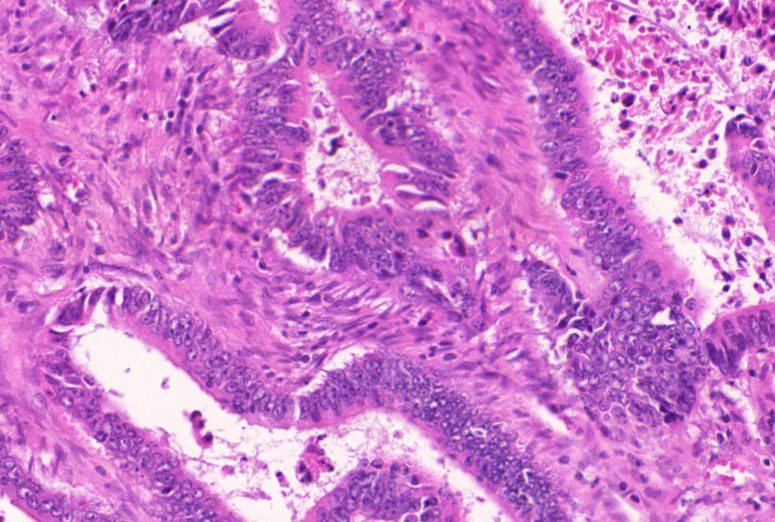

In [25]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

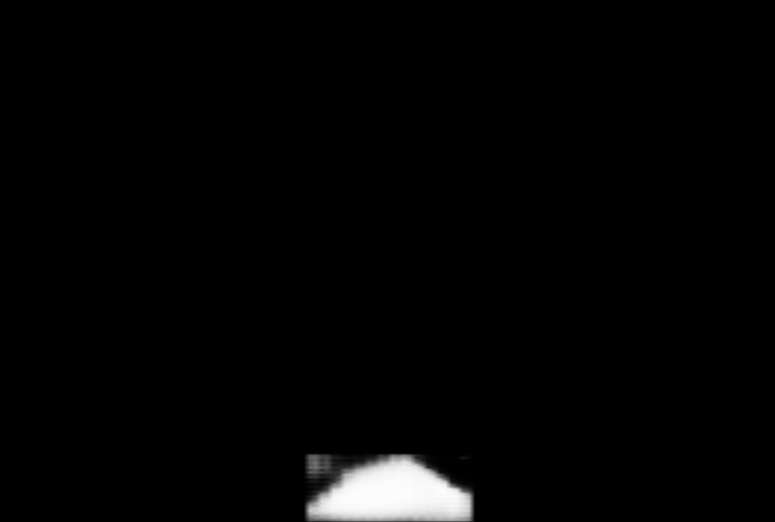

In [26]:
Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy())

In [27]:
num_cells_raw = len(prediction[0]['scores'])
print('Raw predicted number of cells: ', num_cells_raw)

Threshold = 0.6

scores = prediction[0]['scores'][prediction[0]['scores']>Threshold]
print('Scores: ',scores)

num_cells_pred = len(scores)
print('Predicted number of cells: ', num_cells_pred)


Raw predicted number of cells:  68
Scores:  tensor([0.8950, 0.8577, 0.8448, 0.7942, 0.7888, 0.7651, 0.7214, 0.6997, 0.6456,
        0.6216], device='cuda:0')
Predicted number of cells:  10


11


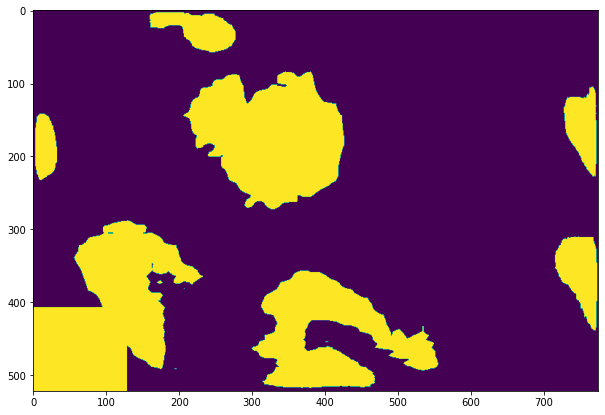

In [28]:
img = prediction[0]['masks'][0, 0].cpu().numpy()

for i in range(1,num_cells_pred):
    layer = prediction[0]['masks'][i, 0].cpu().numpy()

    (_,layer) = cv2.threshold(layer,0.8,1,cv2.THRESH_BINARY)
    img = img+layer

(_,img) = cv2.threshold(img,0,1,cv2.THRESH_BINARY)

plt.figure(figsize=(21,7))
plt.imshow(img)

(_ , n_cells) = label(img, background=0, return_num=True, connectivity=1)
print(n_cells)

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection). 



#Metrics

In [29]:
%%shell

#We need scikit-image >0.18, this is currently not released as a pip package
# To install it, do the following
git clone https://github.com/scikit-image/scikit-image.git
cd scikit-image
pip install -e .

fatal: destination path 'scikit-image' already exists and is not an empty directory.
Obtaining file:///content/drive/My%20Drive/Deep/scikit-image
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2
  Running setup.py develop for scikit-image


In [30]:
os.chdir('/content/drive/My Drive/Deep/scikit-image/skimage')
! ls
import numpy as np
from skimage.measure import label
os.chdir('/content/drive/My Drive/Deep/scikit-image/skimage/metrics')
from set_metrics import hausdorff_distance

_build.py    exposure  __init__.py  __pycache__   segmentation	viewer
color	     feature   io	    registration  setup.py
conftest.py  filters   measure	    restoration   _shared
data	     future    metrics	    scikit-image  transform
draw	     graph     morphology   scripts	  util


#Metrics

In [31]:
class BinaryImageMetrics():
    def __init__(self, y_true, y_pred):
        #TODO: Add documentation
        #TODO: implement Adjusted Rand Index and https://web.stanford.edu/class/cs273/scribing/2004/class8/scribe8.pdf
        
        # Numpy have the bug : ValueError: cannot set WRITEABLE flag to True of this array
        # That is why we copy the array

        # We force the predictions to be binary

        y_true = np.copy(y_true)
        y_pred = np.copy(y_pred)
        y_true[y_true>0]=1
        y_pred[y_pred>0] = 1
        self.y_true= y_true
        self.y_pred = y_pred
        self.y_true_label = label(self.y_true)
        self.y_pred_label = label(self.y_pred)

    def get_count(self):
        count_y_true = np.max(self.y_true_label)
        count_y_pred = np.max(self.y_pred_label)
        if count_y_pred == 0 or count_y_true == 0:
            return 0.0
        else:
            return min(count_y_true/count_y_pred, count_y_pred/count_y_true)

    def get_f1(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = 2*tp / (2*tp +fp + fn)
        return f1
        
    def get_iou(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = tp / (tp +fp + fn)
        return f1

    def get_hausdroff_dist(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
        
        if y_true.max() == 0 or y_pred.max() == 0:
            haus_dist = np.sqrt(y_true.shape[0]*y_true.shape[1])
        else:
            haus_dist = hausdorff_distance(y_true, y_pred)
        return haus_dist

    def get_iou_obj(self):
        iou_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            iou = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_iou(y_true=gi, y_pred=si)
            iou_obj += iou

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            iou = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_iou(y_true=si, y_pred=gi)
            iou_obj += iou

        iou_obj /= 2

        return iou_obj


    def get_f1_obj(self):
        f1_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            f1 = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_f1(y_true=gi, y_pred=si)
            f1_obj += f1

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            f1 = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_f1(y_true=si, y_pred=gi)
            f1_obj += f1

        f1_obj /= 2

        return f1_obj


    def get_hausdorff_obj_distance(self):
        haus_dist_obj = 0
        total_y_pred = np.bincount(self.y_pred.flatten(), minlength=2)[1]
        total_y_true = np.bincount(self.y_true.flatten(), minlength=2)[1]
        
        if total_y_true == 0 or total_y_pred == 0:
            # Note this conversion is different from
            # https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/evaluation/
            # But the Hausdorff distance is not defined for non-overlapping objects.
            # Note that the distance of sqrt(h^2+w^2) is an arbary choice.
            # 0.0 would skew the distance to much to the positive side, and
            # infinite is misleading. 
            # In case both objects are empty, we return the max dist of y_true
            return np.sqrt(self.y_true.shape[0]**2+self.y_true.shape[1]**2)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=False)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((gi.shape[0]*gi.shape[1])/total_y_true)*np.sqrt(gi.shape[0]**2+gi.shape[1]**2)
            else:
                haus_dist = (np.bincount(gi.flatten())[1]/total_y_true)*self.get_hausdroff_dist(y_true=gi, y_pred=si)
            haus_dist_obj += haus_dist

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=True)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((si.shape[0]*si.shape[1])/total_y_pred)*np.sqrt(si.shape[0]**2+si.shape[1]**2)
            else:
                haus_dist = (np.bincount(si.flatten())[1]/total_y_pred)*self.get_hausdroff_dist(y_true=si, y_pred=gi)
            haus_dist_obj += haus_dist

        haus_dist_obj /= 2
        return haus_dist_obj

    def confusion_matrix(self, y_true, y_pred):
        y_true= y_true.flatten()
        y_pred = y_pred.flatten()*2
        cm = y_true+y_pred
        cm = np.bincount(cm, minlength=4)
        tn, fp, fn, tp = cm
        return tp, fp, tn, fn
    
    def _get_overlap(self, idx, return_rectangle=False, y_true_p_switch=False):
        if y_true_p_switch:
            y_pred = self.y_true_label
            y_true = self.y_pred_label
        else:
            y_true = self.y_true_label
            y_pred = self.y_pred_label

        roi_y_true = np.argwhere(y_true == idx)
        roi_y_pred = y_pred[roi_y_true[:,0],roi_y_true[:,1]]

        # Finds max overlap, excluding background
        matching_idx = np.bincount(roi_y_pred)
        if len(matching_idx)<=1:
            matching_idx = -1
        else:
            matching_idx = matching_idx[1:].argmax()+1
        if return_rectangle:
            bbox, _, _ = self._bounding_box(roi_y_true, at_origon=False)
            roi_y_true = y_true[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_pred = y_pred[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_true =(roi_y_true==idx)*1

        else:
            roi_y_true = np.ones((len(roi_y_true)),dtype=int)
        roi_y_pred = (roi_y_pred==matching_idx)*1
        
        return roi_y_true, roi_y_pred
        
    def _bounding_box(self, points, at_origon=False):
        bbox = [min(points[:,0]), min(points[:,1]), max(points[:,0]), max(points[:,1])]
        min_x = bbox[0]
        min_y = bbox[1]
        if at_origon:
            bbox = [bbox[0] - min_x,
                    bbox[1] - min_y,
                    bbox[2] - min_x,
                    bbox[3] - min_y]
        return bbox, min_x, min_y
        

#Metrics calculation


In [32]:
m = np.zeros(5)

pred = np.uint8(img)
true = np.sort(glob.glob("/content/drive/My Drive/Deep/Annotation_cell_count/cell_count/anno_train_23.jpg"))

true = np.uint8(Image.open(true[0]))
(_, true) = cv2.threshold(true, 0.5, 1, cv2.THRESH_BINARY)

pred = np.uint8(pred)
true = np.uint8(true)

metrics = BinaryImageMetrics(true, pred)

m[0] = metrics.get_f1_obj()
m[1] = metrics.get_hausdorff_obj_distance()
m[2] = metrics.get_iou_obj()
m[3] = metrics.get_count()
m[4] = metrics.get_f1()

print('F1-object',metrics.get_f1_obj())
print('Hausdorff',metrics.get_hausdorff_obj_distance())
print('Count',metrics.get_count())
print('IoU object',metrics.get_iou_obj())


F1-object 0.6171729251520609
Hausdorff 157.46751783097437
Count 0.03819444444444445
IoU object 0.5284945773992443
